<img src="https://i.redditmedia.com/acjKxHyGnlZP9BuPcZduptXqr3LL2gNRqtu0572ks08.jpg?w=1024&s=a6bc90189eb102a3b9f1daac35228ac5" style="float: top; height: 300px">

## Classifying Pedestrians in Melbourne

_Sharleen Othman_


In [1]:
import warnings
import itertools
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import proj3d
from sklearn.decomposition import PCA
plt.style.use('fivethirtyeight')


Having a set of pedestrian hourly count for the city of Melbourne, there are a few things I looked at initially.

1. Most populated areas (on average)
2. Distribution of pedestrians throughout the day
3. Distribution of pedestrians throughout the month



In [2]:
ped = pd.read_csv('./data_imgs/main_ped.csv')
ped.head()

Date_Time                 Sensor_Name  Hourly_Counts
0   01-JUN-2009 00:00            Town Hall (West)            194
1   01-JUN-2009 00:00       Collins Place (South)             21
2   01-JUN-2009 00:00       Collins Place (North)              9
3   01-JUN-2009 00:00        Australia on Collins             39
4   01-JUN-2009 00:00  Bourke Street Mall (South)             28

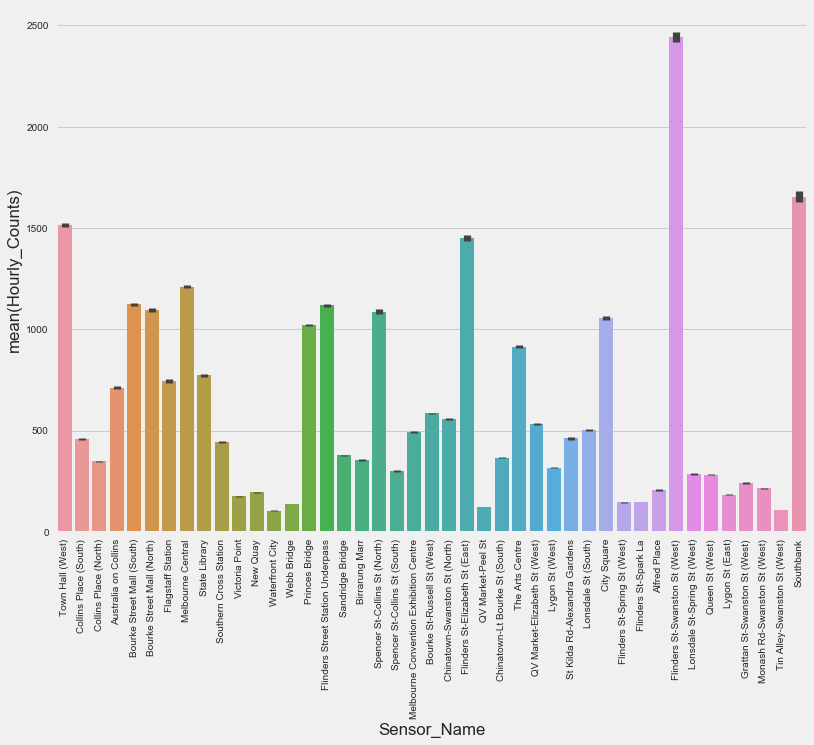

In [3]:
f, ax = plt.subplots(figsize=(12, 9))
g=sns.barplot(x='Sensor_Name', y='Hourly_Counts', data=ped)   
ax.set_xticklabels(labels = ax.get_xticklabels(),rotation=90)
plt.show()

#Flinders Street is most popular area in Melbourne based on average pedestrian count

In [6]:
#tableau map, heatmap

<img src="./data_imgs/heatmap_ped.png">

In [5]:
ped.set_index('Date_Time', inplace=True)
ped.index = pd.to_datetime(ped.index) 
ped.dtypes

Hourly_Counts    int64
dtype: object

In [7]:
ped_monthly = ped['Hourly_Counts'].resample('MS').sum() #looking at total pedestrians recorded for each month. Note that this does not reflect unique pedestrians
ped_monthly = ped_monthly.fillna(ped_monthly.bfill())
ped_monthly.head()

Date_Time
2015-01-01    1738953
2015-02-01    1645443
2015-03-01    1966429
2015-04-01    1804321
2015-05-01    1775415
Freq: MS, Name: Hourly_Counts, dtype: int64

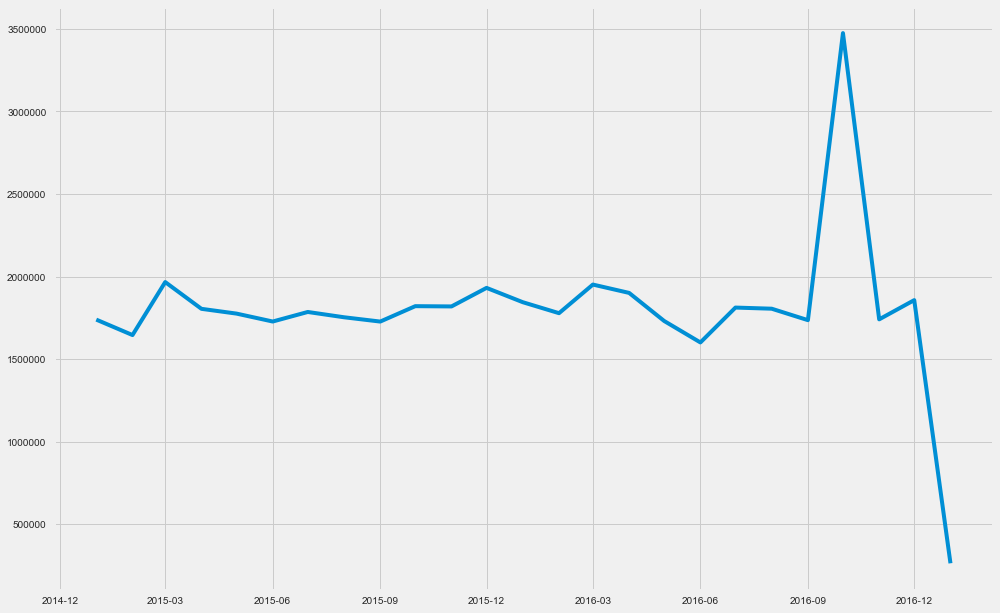

In [8]:
plt.figure(figsize=(15,10))
plt.plot(ped_monthly)
plt.show()

#we can see that starting from mid-2013, melbourne population has been growing, or at the very least, more people are out in the city areas.
#I also notice there is a spike in OCtober 2016
#Is it going into a downward trend?

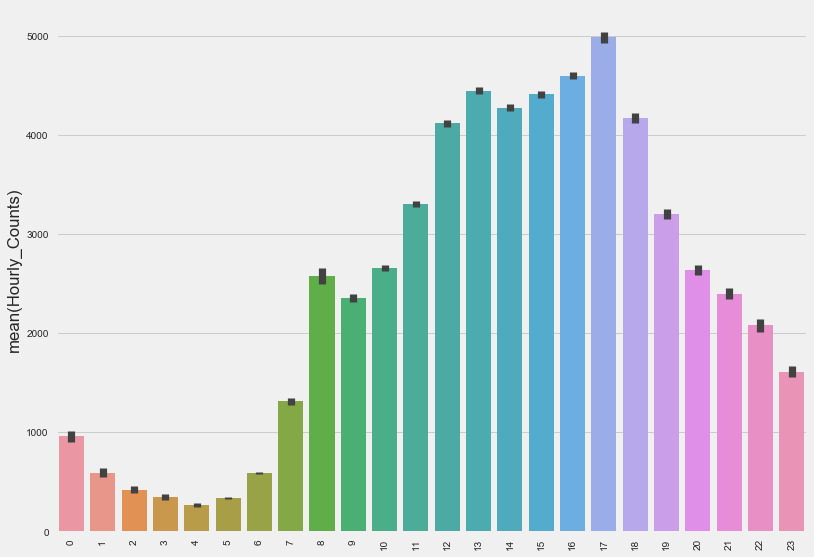

In [9]:
f, ax = plt.subplots(figsize=(12, 9))
g=sns.barplot(x=ped.index.hour, y='Hourly_Counts', data=ped)   
ax.set_xticklabels(labels = ax.get_xticklabels(),rotation=90)
plt.show()

#On average for all areas, peak hours where Melbournians are up and about in the city area is between noon and 5pm


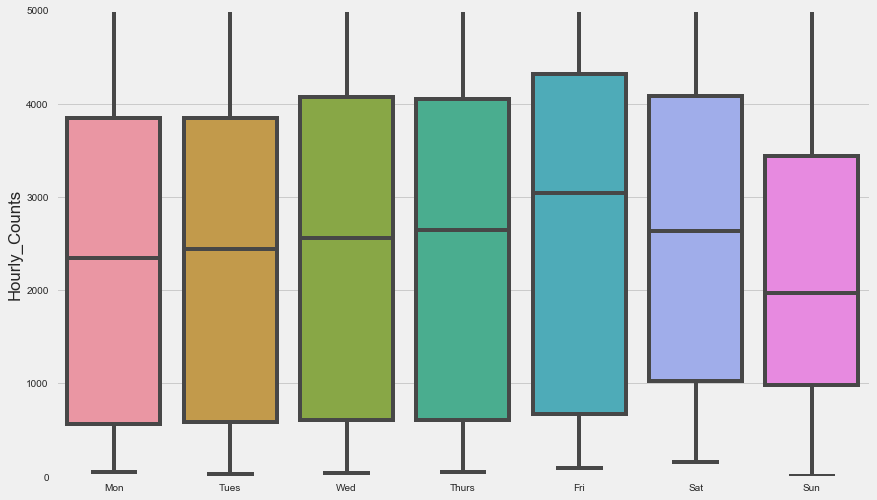

In [45]:
f, ax = plt.subplots(figsize=(13, 8))
g=sns.boxplot(x=ped.index.dayofweek, y='Hourly_Counts', data=ped)   
ax.set_xticklabels(['Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun'])
ax.set_ylim([0, 5000])
plt.show()

# Fridays generally get the most pedestrians out and about.

In [11]:
#tableau plot
#different areas have different average pedestrian trends

<img src="./data_imgs/different_areas.png">

Now that I've looked at it, there are a few questions I can ask.

1. Are there different group of pedestrians and how can I identify them? Locals and non-locals?
2. Some areas are more populated than others, why?
3. Average pedestrian trend are obviously different from area to area but what types are there?
4. Where there are spikes or dips that are not normal trend, what happened?

For a start, since I don't know the labels for my different pedestrian groups, I'm going to use unsupervised machine learning, specifically, clustering. This will help me look for specific trends/groups in my dataset if there are any. 

PCA will help me determine the most important features to determine which are most appropriate to perform the classification. In this case, my hours of the day are my features.

In [4]:
#I already know, Flinders St Swanston St has the most pedestrians. 
# Taking this as indicative of what's going on in Melbourne majority of the time, I'll hone in on this area for further analysis first.
# I could've use all areas but the dataset is so large, it takes a little longer to run my code on it

ped = ped[ped['Sensor_Name']== 'Flinders St-Swanston St (West)']
ped = ped.loc[:,['Date_Time','Hourly_Counts']] 

ped.head()

Date_Time  Hourly_Counts
1012367   01-JAN-2015 00:00           3836
1012400   01-JAN-2015 01:00           4725
1012433   01-JAN-2015 02:00           4592
1012467   01-JAN-2015 03:00           3612
1012500   01-JAN-2015 04:00           2432

In [12]:
ped.dtypes
#My date time should be in datetime format for me to easily toggle between months, hours and days.

Hourly_Counts    int64
dtype: object

In [13]:
#Pivot to get the right rows and columns. 

pivoted = ped.pivot_table(['Date_Time', 'Hourly_Counts'],
                           index=ped.index.date,
                           columns=ped.index.hour,
                           fill_value=0)
pivoted.head()

Hourly_Counts                                                       \
                      0     1     2     3     4     5    6     7     8     9    
2015-01-01          3836  4725  4592  3612  2432  1252  712   494   594   966   
2015-01-02           875   269   104    97   138   209  379   650  1221  1561   
2015-01-03          1217   634   402   313   242   277  293   424   742  1185   
2015-01-04          1129   722   528   410   269   266  220   374   552  1017   
2015-01-05           540   201   113   113   154   247  452  1159  2070  2063   

            ...                                                               
            ...     14    15    16    17    18    19    20    21    22    23  
2015-01-01  ...   3140  3451  3158  3122  3036  2502  2246  1839  1612  1604  
2015-01-02  ...   3455  3385  3422  3174  2815  2560  2250  2408  2022  1617  
2015-01-03  ...   2513  2376  2366  2221  2036  1917  1784  1694  1679  1483  
2015-01-04  ...   3636  3886  3712  3450  2956  2591  2259  1730  1383   974  
2015-01-05  ...   4343  4254  4476  4645  3719  2823  2229  1834  1625  1835  

[5 rows x 24 columns]

In [14]:
X = pivoted.values
X.shape

(736, 24)

In [15]:
X[0,:]

array([3836, 4725, 4592, 3612, 2432, 1252,  712,  494,  594,  966, 1503,
       2229, 2688, 3024, 3140, 3451, 3158, 3122, 3036, 2502, 2246, 1839,
       1612, 1604])

In [17]:
# Let's go ahead and use PCA now. 
pca = PCA()
pca.fit(pivoted)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [18]:
# Quick way of viewing, rather than looping through each feature
pc1_ev = pca.components_[0]
pd.Series(pc1_ev, index=range(0,24))

pc2_ev = pca.components_[1]
pd.Series(pc2_ev, index=range(0,24))

0     0.273089
1     0.198492
2     0.146553
3     0.113911
4     0.074366
5     0.028131
6    -0.028770
7    -0.144729
8    -0.348812
9    -0.125109
10    0.010707
11    0.072429
12    0.053644
13    0.086216
14    0.132372
15    0.127766
16    0.100922
17   -0.006415
18    0.155201
19    0.276189
20    0.294491
21    0.343067
22    0.414971
23    0.386548
dtype: float64

In [19]:
# Reminder of PC1 and PC2

pcs = pd.DataFrame({'PC1': pc1_ev, 'PC2': pc2_ev},
             index=range(0,24))
pcs

#If I look at this dataframe, I can tell PC1 has something going on at 8am and 5pm since it's larger in magnitude compared to the rest.
#PC2 has something going on 8am and then late at night from 9pm.
#PC1 could be my work commuters since it follows working hours. 

PC1       PC2
0   0.272222  0.273089
1   0.246806  0.198492
2   0.198412  0.146553
3   0.163385  0.113911
4   0.097830  0.074366
5   0.037214  0.028131
6  -0.037785 -0.028770
7  -0.187775 -0.144729
8  -0.436014 -0.348812
9  -0.231364 -0.125109
10 -0.123880  0.010707
11 -0.070969  0.072429
12 -0.134892  0.053644
13 -0.134454  0.086216
14 -0.079974  0.132372
15 -0.116006  0.127766
16 -0.194418  0.100922
17 -0.390863 -0.006415
18 -0.332317  0.155201
19 -0.200057  0.276189
20 -0.156465  0.294491
21 -0.163296  0.343067
22 -0.147798  0.414971
23 -0.130799  0.386548

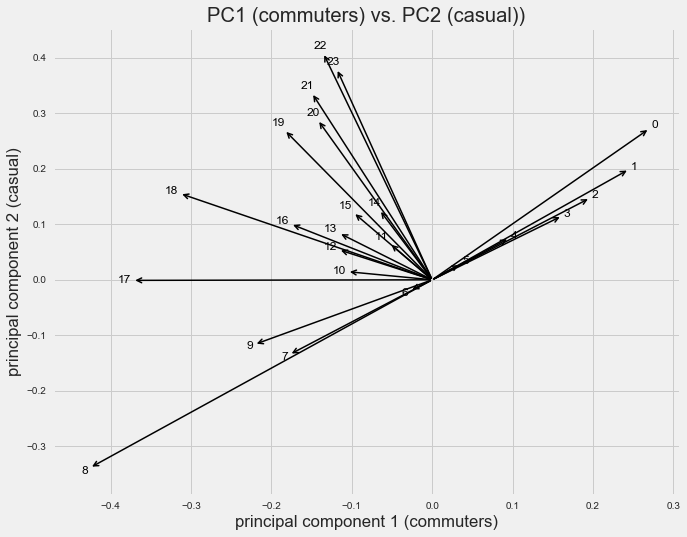

In [20]:
fig, ax = plt.subplots(figsize=(10,8))
ax.scatter(pcs.PC1.values, pcs.PC2.values, s=0)

for i, txt in enumerate(pcs.index.values):
    ax.annotate(txt, (0, 0), (pcs.PC1.values[i], pcs.PC2.values[i]),
            arrowprops=dict(arrowstyle='<-', color='black', linewidth=1.5),
            xycoords='data', textcoords='data', fontsize=12, color="black")

ax.set_title('PC1 (commuters) vs. PC2 (casual))')
ax.set_xlabel('principal component 1 (commuters)')
ax.set_ylabel('principal component 2 (casual)')
plt.show()

# The graph shows this visually

In [21]:
#Now let's see how many components I can take to explain the most variance 

# Calculating Eigenvectors and eigenvalues of Cov matirx
mean_vec = np.mean(X, axis=0)
cov_mat = np.cov(X.T)
eig_vals, eig_vecs = np.linalg.eig(cov_mat)

In [22]:
#Code was found on https://www.kaggle.com/arthurtok/principal-component-analysis-with-kmeans-visuals

# Create a list of (eigenvalue, eigenvector) tuples
eig_pairs = [ (np.abs(eig_vals[i]),eig_vecs[:,i]) for i in range(len(eig_vals))]

# Sort from high to low
eig_pairs.sort(key = lambda x: x[0], reverse= True)

# Calculation of Explained Variance from the eigenvalues
tot = sum(eig_vals)
var_exp = [(i/tot)*100 for i in sorted(eig_vals, reverse=True)] # Individual explained variance
cum_var_exp = np.cumsum(var_exp) # Cumulative explained variance

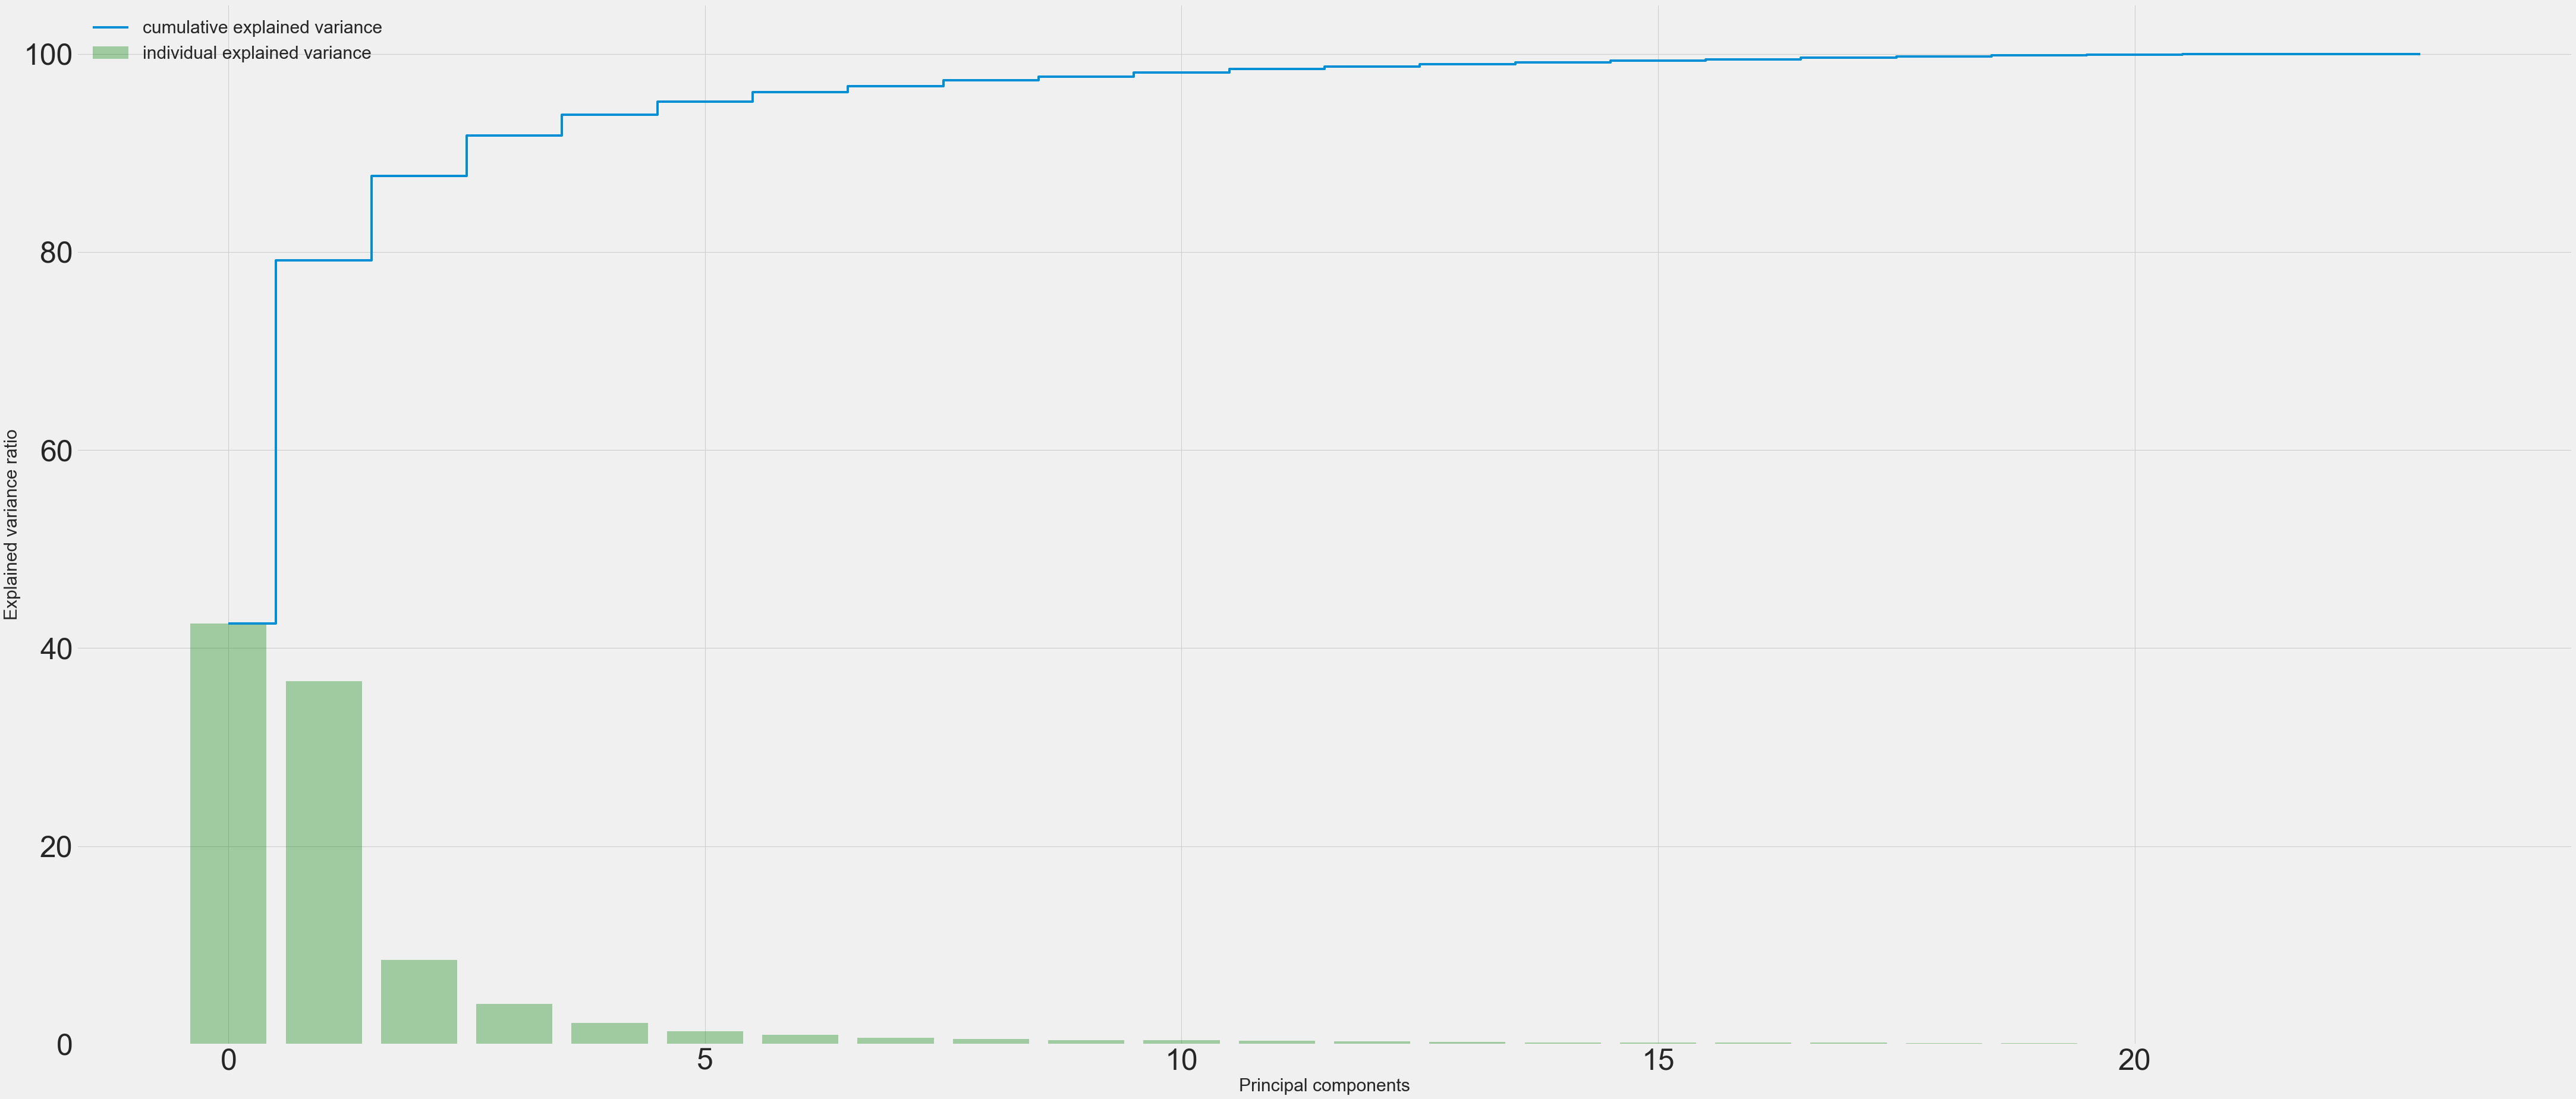

In [23]:
# PLOT OUT THE EXPLAINED VARIANCES SUPERIMPOSED 
plt.figure(figsize=(67, 30))
plt.bar(range(len(pivoted.columns)), var_exp, alpha=0.3333, align='center', label='individual explained variance', color = 'g')
plt.step(range(len(pivoted.columns)), cum_var_exp, where='mid',label='cumulative explained variance')
plt.ylabel('Explained variance ratio',fontsize=30)
plt.xlabel('Principal components',fontsize=30)
plt.legend(loc='best',fontsize=30)
plt.xticks(fontsize = 50)
plt.yticks(fontsize = 50)
plt.show()

In [24]:
#looking at above, I really only want to use two PCs that make the most difference.
Xpca = PCA(0.75).fit_transform(X)
Xpca.shape
Xpca
Xpca[:, 0]

array([  7.31421866e+03,   2.82940082e+03,   5.24862263e+03,
         3.70468475e+03,   6.27671702e+02,   7.50524119e+02,
         1.43953136e+03,   7.30749017e+02,  -6.31693719e-01,
         2.20306855e+03,   3.90496309e+03,   7.67743950e+02,
         1.01069360e+03,   8.22408049e+01,  -2.75396399e+01,
        -1.89031902e+03,   1.52768451e+03,   2.35971454e+03,
        -1.22223828e+03,  -1.95416145e+03,  -1.68923327e+03,
        -9.39314588e+02,  -2.32898007e+03,  -4.74122521e+02,
         1.72691855e+03,   3.52171246e+02,  -4.53157071e+00,
        -1.06194808e+03,  -8.23303721e+02,  -1.27559064e+03,
         1.92855202e+03,   4.06971603e+03,   7.49378784e+02,
         3.60731334e+01,  -3.22650547e+02,  -6.44817740e+02,
        -1.43400832e+03,   2.52449814e+03,   4.03588289e+03,
        -6.61064112e+00,  -2.47415594e+02,   4.59501315e+01,
        -9.47865918e+02,  -1.37274011e+03,  -1.13717804e+03,
         2.67141746e+03,   1.98497243e+02,  -4.12081232e+02,
        -1.14004600e+03,

In [25]:
Xpcadf = pd.DataFrame(Xpca)
Xpcadf.shape
Xpcadf
#in a dataframe

0            1
0    7314.218657  2164.333306
1    2829.400818  -570.039159
2    5248.622625 -1499.947727
3    3704.684746  -575.348896
4     627.671702  -678.629860
5     750.524119  -973.617807
6    1439.531357 -1538.239031
7     730.749017  -727.419308
8      -0.631694   242.703899
9    2203.068552  1204.372806
10   3904.963093   104.694883
11    767.743950 -1606.087730
12   1010.693596 -1955.565335
13     82.240805 -1338.698859
14    -27.539640  -946.764853
15  -1890.319019  1520.433211
16   1527.684509  1787.950184
17   2359.714535  1410.781057
18  -1222.238285  -306.969388
19  -1954.161450   613.082924
20  -1689.233275   527.984352
21   -939.314588   440.542899
22  -2328.980067  1939.009904
23   -474.122521  3933.889429
24   1726.918547  2160.621823
25    352.171246  2033.951856
26     -4.531571 -1009.016763
27  -1061.948083  -618.549523
28   -823.303721  -581.011685
29  -1275.590637  1175.971127
..           ...          ...
706 -1624.604208    36.348055
707 -1317.734936  -360.618761
708 -2925.024823  2296.255307
709  1399.278499  3705.777281
710  3278.941267  1834.215820
711  -902.939506  -356.470646
712  -410.768783  -772.280245
713 -1180.294156   -12.115547
714 -2162.883601  1232.584630
715 -2882.838496  3208.531731
716  2219.145848  3836.029269
717  3419.058623  1134.731317
718  -872.988355   -84.199083
719  -988.576664   271.820597
720 -1870.371212  1071.918063
721 -2433.191099  2268.014471
722 -1228.682895  3220.195570
723  2818.005283  2884.572497
724  4372.182579  1888.878182
725  1310.268918  -177.516008
726  1908.723745    41.332482
727   613.892724   541.602045
728  2645.701237  -927.123898
729   798.865416  1227.377204
730   478.876444  5220.283916
731  6734.765628  2687.625105
732  3681.301650 -1151.553633
733   283.533245  -110.256459
734   430.778151  -367.798018
735   783.776562  -348.398163

[736 rows x 2 columns]

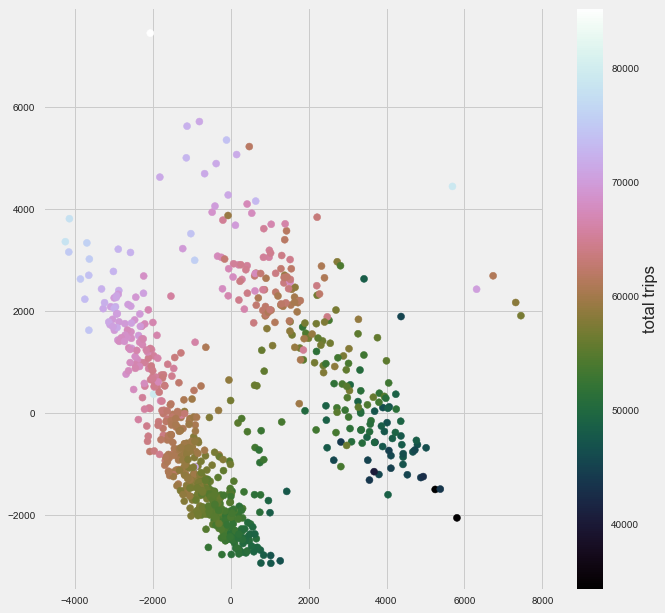

In [26]:
plt.rcParams["figure.figsize"] = (10,10)

total_trips = X.sum(1)
plt.scatter(Xpca[:, 0], Xpca[:, 1], c=total_trips,
            cmap='cubehelix')
plt.colorbar(label='total trips')
plt.show()

#here I can clearly see two clusters and they both increase in total trips along the axis, in the same direction.
#This means they both equally increase in pedestrian count along some kind of variable, since I used time as my variable, they seem to both increase in count with time.

In [27]:
#Using different clustering methods to find the best fit

from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.mixture import GMM

def plot_competing_algos(X, title, n_clusters_kmeans=2, n_clusters_agg=2,
                         dbscan_eps=2, dbscan_min_samples=5,gmm=2, gmmcovariance_type='full', gmmrandom_state=0):
#     
    fig, axarr = plt.subplots(1,4, figsize=(24,7))
    
    # K-MEANS:
    kmeans = KMeans(n_clusters=n_clusters_kmeans)
    kmeans.fit(X)
    
    X['kmeans_label'] = kmeans.labels_
        
    for label in X.kmeans_label.unique():
        X_ = X[X.kmeans_label == label]
        axarr[0].scatter(X_.iloc[:,0], X_.iloc[:,1], s=70, 
                          label=label, alpha=0.9)
        
    axarr[0].set_title(title+' '+'kmeans', fontsize=20)
    axarr[0].legend(loc='lower right')
  
    
    # HIERARCHICAL/AGGLOMERATIVE:
    aggclust = AgglomerativeClustering(n_clusters=n_clusters_agg)
    aggclust.fit(X)
    
    X['aggclust_label'] = aggclust.labels_
        
    for label in X.aggclust_label.unique():
        X_ = X[X.aggclust_label == label]
        axarr[1].scatter(X_.iloc[:,0], X_.iloc[:,1], s=70, 
                         label=label, alpha=0.9)
        
    axarr[1].set_title(title+' '+'agglomerative', fontsize=20)
    axarr[1].legend(loc='lower right')
   
    
    # DBSCAN:
    dbscan = DBSCAN(eps=dbscan_eps, min_samples=dbscan_min_samples)
    dbscan.fit(X)
    
    X['dbscan_label'] = dbscan.labels_
        
    for label in X.dbscan_label.unique():
        X_ = X[X.dbscan_label == label]
        axarr[2].scatter(X_.iloc[:,0], X_.iloc[:,1], s=70, 
                          label=label, alpha=0.9)
        
    axarr[2].set_title(title+' '+'DBSCAN', fontsize=20)
    axarr[2].legend(loc='lower right')

    
    # GMM:
    gmm = GMM(gmm, covariance_type=gmmcovariance_type, random_state=gmmrandom_state)
    gmm.fit(X)
    
    X['gmm_labels'] = gmm.predict(X)
    
    for label in X.gmm_labels.unique():
        X_ = X[X.gmm_labels == label]
        axarr[3].scatter(X_.iloc[:,0], X_.iloc[:,1], s=70, 
                          label=label, alpha=0.9)
        
    axarr[3].set_title(title+' '+'GMM', fontsize=20)
    axarr[3].legend(loc='lower right')
  

/Users/sharleenies/anaconda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:52: DeprecationWarning: Class GMM is deprecated; The class GMM is deprecated in 0.18 and will be  removed in 0.20. Use class GaussianMixture instead.
  warnings.warn(msg, category=DeprecationWarning)
/Users/sharleenies/anaconda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The functon distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/Users/sharleenies/anaconda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/Users/sharleenies/anaconda/lib/python3.6/site-packages/sklea

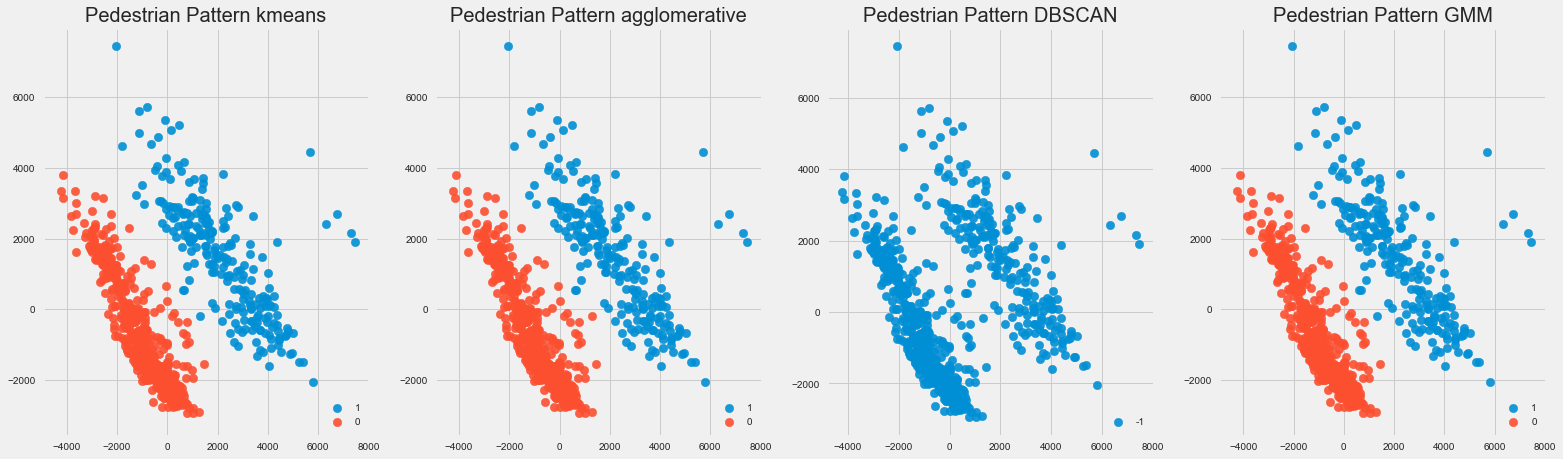

In [28]:
plot_competing_algos(Xpcadf, 'Pedestrian Pattern', n_clusters_kmeans=2, n_clusters_agg=2,
                     dbscan_eps=0.001, dbscan_min_samples=2,gmm=2, gmmcovariance_type='full', gmmrandom_state=0)
plt.show()   

#All except DBSCAN gives me pretty good distinct clusters. 

Advantages of K-Means:

1. Running Time

2. Better for high dimensional data.

3. Easy to interpret and Implement.

Disadvantages of K-Means:

1. Assumes the clusters as spherical, so does not work efficiently with complex geometrical shaped data(Mostly Non-Linear)

2. Hard Assignment might lead to mis grouping.

In [29]:
#add cluster labels back to my original dataframe which has the date and time so I can relate back to my original data points

kmeans_model = KMeans(n_clusters=2)
kmeans_model.fit(Xpcadf)

pivoted['kmeans_cluster'] = kmeans_model.labels_
ped = ped.join(pivoted['kmeans_cluster'], on=ped.index.date)

ped.head()

Hourly_Counts  kmeans_cluster
Date_Time                                         
2015-01-01 00:00:00           3836               1
2015-01-01 01:00:00           4725               1
2015-01-01 02:00:00           4592               1
2015-01-01 03:00:00           3612               1
2015-01-01 04:00:00           2432               1

In [30]:
# change the structure so I can graph hourly timeline
by_hour = ped.groupby(['kmeans_cluster', ped.index.time]).mean()
by_hour

Hourly_Counts
kmeans_cluster                        
0              00:00:00     485.163776
               01:00:00     211.685934
               02:00:00     133.221580
               03:00:00     112.526012
               04:00:00     130.739884
               05:00:00     290.073218
               06:00:00     658.545279
               07:00:00    1635.246628
               08:00:00    3321.514451
               09:00:00    2687.131021
               10:00:00    2765.772640
               11:00:00    3292.273603
               12:00:00    4187.973025
               13:00:00    4494.504817
               14:00:00    4237.894027
               15:00:00    4417.718690
               16:00:00    4718.516378
               17:00:00    5411.857418
               18:00:00    4413.882466
               19:00:00    3216.855491
               20:00:00    2596.321773
               21:00:00    2345.186898
               22:00:00    1957.125241
               23:00:00    1485.009634
1              00:00:00    1959.334677
               01:00:00    1396.330645
               02:00:00    1033.379592
               03:00:00     827.645161
               04:00:00     559.141129
               05:00:00     437.032258
               06:00:00     437.790323
               07:00:00     638.770161
               08:00:00    1023.120968
               09:00:00    1662.169355
               10:00:00    2439.169355
               11:00:00    3316.068548
               12:00:00    3965.951613
               13:00:00    4339.286290
               14:00:00    4356.084677
               15:00:00    4391.258065
               16:00:00    4349.044355
               17:00:00    4095.427419
               18:00:00    3656.629032
               19:00:00    3176.536290
               20:00:00    2717.588710
               21:00:00    2512.689516
               22:00:00    2342.375000
               23:00:00    1877.504032

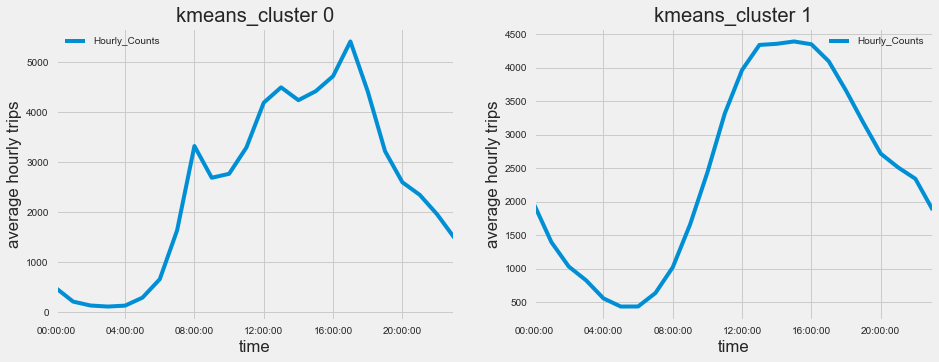

In [47]:
fig, ax = plt.subplots(1,2,figsize=(14, 5))
hourly_ticks = 4 * 60 * 60 * np.arange(6)

for i in range(2):
    by_hour.ix[i].plot(ax=ax[i], xticks=hourly_ticks)
    ax[i].set_title('kmeans_cluster {0}'.format(i))
    ax[i].set_ylabel('average hourly trips')
plt.show()

#initial thought that cluster 0 followed a working hour schedule was correct.
#but it also looks like the group includes both working pedestrians as well as casual pedestrians as they add on to the count later in the day
#nonetheless I can tell that cluster 1 is my non-working folk

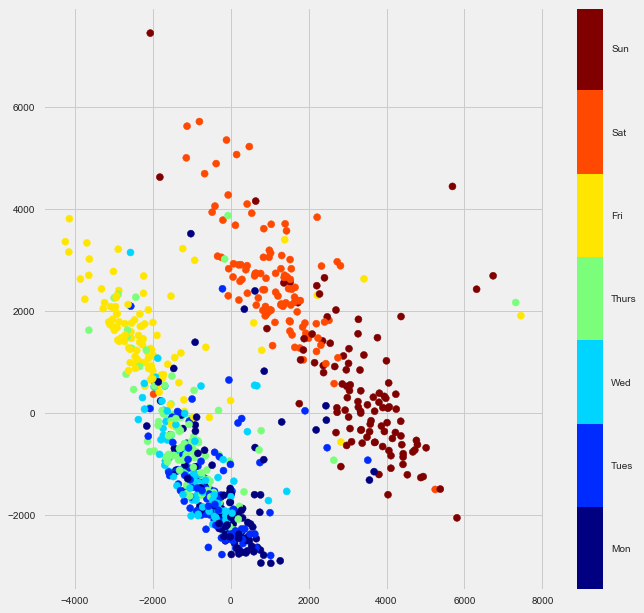

In [32]:
# using the datetime on our table, we can see what day of the week these days correspond with
# so our two clusters give us weekday and weekend separation.
# I can see some weekdays following a weekend pattern

dayofweek = pd.to_datetime(pivoted.index).dayofweek
plt.scatter(Xpca[:, 0], Xpca[:, 1], c=dayofweek,
            cmap=plt.cm.get_cmap('jet', 7))
cb = plt.colorbar(ticks=range(7))
cb.set_ticklabels(['Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun'])
plt.clim(-0.5, 6.5);
plt.show()

In [33]:
results = pd.DataFrame({'cluster': pivoted.kmeans_cluster,
                        'is_weekend': (dayofweek > 4),
                        'weekday': pivoted.index.map(lambda x: x.strftime('%a'))},
                       index=pivoted.index)
results.head()

cluster is_weekend weekday
2015-01-01        1      False     Thu
2015-01-02        1      False     Fri
2015-01-03        1       True     Sat
2015-01-04        1       True     Sun
2015-01-05        0      False     Mon

In [34]:
weekend_but_working = results.query('cluster == 0 and is_weekend')
print(len(weekend_but_working))
print(weekend_but_working)


#there is one weekend day where Melbourne pedestrians were showing up for work?
#ANZAC DAY

1
            cluster is_weekend weekday
2015-04-25        0       True     Sat


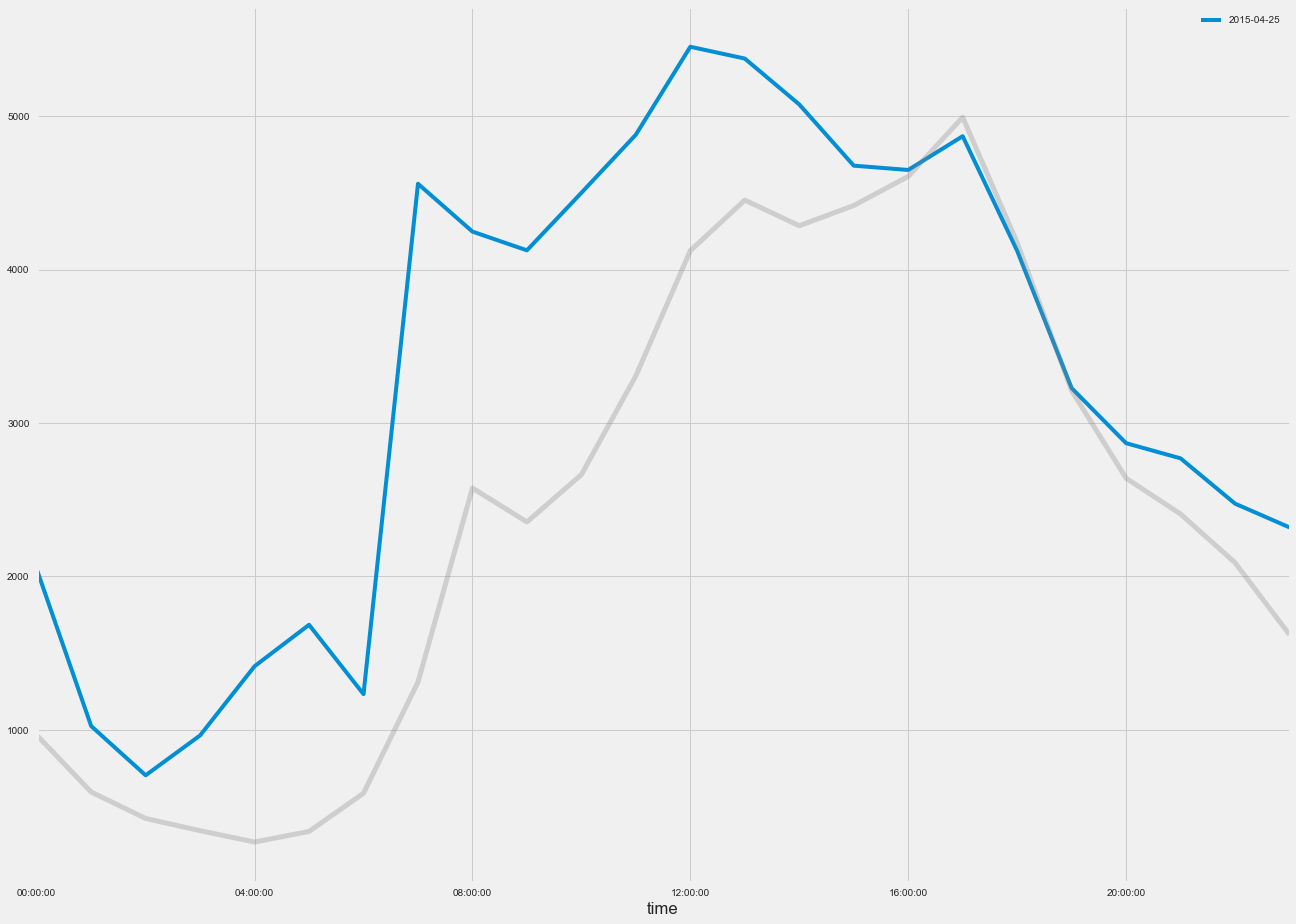

In [35]:
plt.rcParams["figure.figsize"] = (20,15)
weekend = dayofweek > 4
odd = pivoted.index[weekend & (pivoted.kmeans_cluster == 0)]
odd


all_days = ped.pivot_table('Hourly_Counts', index=ped.index.time, columns=ped.index.date)
all_days.loc[:,odd].plot()
all_days.mean(1).plot(color='gray', lw=5, alpha=0.3,
                      xticks=hourly_ticks)
plt.show()

#On Anzac day, Melbourne residents are arriving in the city earlier than usual (Dawn service?)

In [36]:
midweek_holidays = results.query('cluster == 1 and not is_weekend')
# midweek_holidays['Date'] = [i.date for i in midweek_holidays.index]
len(midweek_holidays)

#there were 29 weekdays where Melbourne pedestrians were NOT showing up for work

29

In [38]:

from datetime import datetime, timedelta
holidays16 = pd.read_csv('./data_imgs/australianpublicholidays-201617.csv.csv')
holidays15 = pd.read_csv('./data_imgs/australianpublicholidays-201516.csv')

holidays = pd.concat([holidays16,holidays15])
holidays['Date_Time'] = [datetime.strptime(str(i), '%Y%m%d') for i in holidays.Date]
# holidays['Date_Time'] = holidays.Date_Time
holidays = holidays.loc[:,['Holiday Name','Date_Time']]
holidays.set_index('Date_Time', inplace=True)



In [39]:
explained = pd.merge(midweek_holidays, holidays, left_index=True, right_index=True, how='left')
explained.drop_duplicates() 

#all can be explained by some sort of event.
#This also gives me an idea of what to expect later on when I perform Time Series. 
#Besides, worldwide holidays such as New Years and Christmas, Australians also enjoy Proclamation day, Melbourne Cup Day, AFL Grand FInal, Queen's Birthday, Eight Hours Day, Canberra Day, Australia Day, March Public Holiday.


cluster is_weekend weekday            Holiday Name
2015-01-01        1      False     Thu          New Year's Day
2015-01-02        1      False     Fri                     NaN
2015-01-26        1      False     Mon           Australia Day
2015-03-09        1      False     Mon    March public holiday
2015-03-09        1      False     Mon            Canberra Day
2015-03-09        1      False     Mon         Eight Hours Day
2015-03-09        1      False     Mon              Labour Day
2015-04-03        1      False     Fri             Good Friday
2015-04-06        1      False     Mon           Easter Monday
2015-06-08        1      False     Mon        Queen's Birthday
2015-10-02        1      False     Fri         AFL Grand Final
2015-11-03        1      False     Tue       Melbourne Cup Day
2015-12-24        1      False     Thu           Christmas Eve
2015-12-25        1      False     Fri           Christmas Day
2015-12-28        1      False     Mon              Boxing Day
2015-12-28        1      False     Mon        Proclamation Day
2015-12-30        1      False     Wed                     NaN
2015-12-31        1      False     Thu          New Year's Eve
2016-01-01        1      False     Fri          New Year's Day
2016-01-26        1      False     Tue           Australia Day
2016-03-28        1      False     Mon          Easter Tuesday
2016-12-26        1      False     Mon   Christmas Day holiday
2016-12-27        1      False     Tue   Christmas Day holiday
2016-12-27        1      False     Tue      Boxing Day holiday
2016-12-27        1      False     Tue        Proclamation Day
2016-12-29        1      False     Thu                     NaN
2017-01-02        1      False     Mon  New Year's Day Holiday

In [40]:
explained[explained['Holiday Name'].isnull()]
# Those that don't fall on a holiday are usually right before or after new year holidays.

cluster is_weekend weekday Holiday Name
2015-01-02        1      False     Fri          NaN
2015-12-30        1      False     Wed          NaN
2016-12-23        1      False     Fri          NaN
2016-12-28        1      False     Wed          NaN
2016-12-29        1      False     Thu          NaN
2016-12-30        1      False     Fri          NaN